In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


In [2]:
path_v1 = "./data/winemag-data-130k-v2.csv" 
path_v2 = "./data/winemag-data_first150k.csv"
col_idx = 0
train_size, test_size, val_size = 0.8, 0.2, 0.2
columns = ['description', 'points']
transform_target = 'normalize'

In [3]:
def load_data(path_v1: str, path_v2: str, columns: list, col_idx: int):
  """
  Load and concatenate two datasets with removing duplicates.
  param path_v1: import path of first dataset
  param path_v2: import path of second dataset
  param columns: list of columns to preserve in dataframe
  param col_idx: index of column given in input columns list 
                 on which look for duplicates in dataframe
  return:        pandas dataframe
  """
  
  df_v1 = pd.read_csv(path_v1, index_col=0)
  df_v1 = df_v1[columns]
  # remove numbers form column description from first dataframe
  df_v1.description = df_v1.description.str.replace('\d+', '')

  df_v2 = pd.read_csv(path_v2, index_col=0)
  df_v2 = df_v2[columns]
  # remove numbers form column description from second dataframe
  df_v2.description = df_v2.description.str.replace('\d+', '')

  df = pd.concat([df_v1, df_v2])

  # dropping duplicte values
  df.drop_duplicates(subset = columns[col_idx],
                       keep = 'first', inplace = True)
  
  return df

In [4]:
def split_data(df: pd.DataFrame, train_size: float, test_size: float, val_size: float):
  """
  Split dataset on train, test and validation subsets.
  param df:          input dataframe
  param train_size:  fraction of train size
  param test_size:   fraction of test size
  param val_size:    fraction of validation size
  return:            dictionary, keys=names of dataframes, columns=dataframes
  """
  
  # shuffle dataset
  df = df.sample(frac = 1)
  
  # split on test and train set
  text_train, text_test, y_train, y_test = train_test_split(df.description, df.points,
                                           test_size=test_size, train_size=train_size)
  
  y_train, y_test = y_train.astype('float'), y_test.astype('float')

  dataset_dict = {
      'text_train': text_train,
      'y_train': y_train,
      'text_test': text_test,
      'y_test': y_test
  }

  return dataset_dict

In [5]:
def transform_data(df_data: dict, transform: str):
    """
    Encode input textual features and transform continuus target variable (standardization, normalization).
    param df_data:   dictionary, keys=names of dataframes, columns=dataframes
    param transform: name of the target variable transformation
    return:          dictionary, keys=names transformed data and scaler, columns=transformed data and scaler object
    """
    # vectorize input text to numerical features
    count_vect_train = CountVectorizer(max_features=100, stop_words='english')
    df_train = count_vect_train.fit_transform(df_data['text_train'])

    count_vect_test = CountVectorizer(max_features=100, stop_words='english')
    df_test = count_vect_test.fit_transform(df_data['text_test'])
    
    # apply tf-idf transform
    tf_transformer_train = TfidfTransformer(use_idf=True).fit(df_train)
    df_train_encode = tf_transformer_train.transform(df_train)

    tf_transformer_test = TfidfTransformer(use_idf=True).fit(df_test)
    df_test_encode = tf_transformer_test.transform(df_test)
    
    df_data['y_train'] = df_data['y_train'].to_numpy().reshape(-1, 1)
    df_data['y_test'] = df_data['y_test'].to_numpy().reshape(-1, 1)
    
    # apply target variable transformation
    if transform == 'normalize':
        scaler = MinMaxScaler()
        scaler.fit(df_data['y_train'])
        train_y = scaler.transform(df_data['y_train'])
        test_y = scaler.transform(df_data['y_test'])
    
    elif transform == 'standardize':
        scaler = StandardScaler()
        scaler.fit(df_data['y_train'])
        train_y = scaler.transform(df_data['y_train'])
        test_y = scaler.transform(df_data['y_test'])
    
    else:
        train_y = df_data['y_train']
        test_y = df_data['y_test']
        scaler = None
    
    train_y, test_y = train_y.ravel(), test_y.ravel()
    
    transformed_data = {
        'text_train': df_train_encode,
        'y_train': train_y,
        'text_test': df_test_encode,
        'y_test': test_y,
        'scaler': scaler
    }
    
    return transformed_data

In [6]:
# call data transformation functions
df = load_data(path_v1, path_v2, columns, col_idx)
df_data = split_data(df, train_size, test_size, val_size)
transformed_data = transform_data(df_data, transform_target)

In [7]:
def get_best_model(models, X_train, Y_train):
    """
    Based on cross validation score return model with best average score.
    param models: dictionary with predefined models
    param X_train: input features, numpy array
    param Y_train: target variable, numpy array
    """
    avg_score = {key: 0 for key in models.keys()}
    
    for model in models.keys():
        print(model)
        avg_score[model] = np.mean(cross_val_score(models[model], X_train, Y_train, cv=5, n_jobs=-1))
        print('One iteration done! ')
    return avg_score

In [ ]:
models = {
    'gb': GradientBoostingRegressor(n_iter_no_change=10),
    'rf': RandomForestRegressor(n_jobs=-1)
}

avg_score = get_best_model(models, transformed_data['text_train'], transformed_data['y_train'])

gb
One iteration done! 
rf


In [60]:
from sklearn.metrics import mean_absolute_error

y_real = transformed_data['scaler'].inverse_transform(transformed_data['y_test'].reshape(-1, 1))
y_predict = transformed_data['scaler'].inverse_transform(reg.predict(transformed_data['text_test']).reshape(-1, 1))

mean_absolute_error(y_real, y_predict)

2.51713270610739

In [40]:
reg.predict(transformed_data['text_test'])

array([0.41701953, 0.32271637, 0.42477637, ..., 0.386571  , 0.37783014,
       0.37495006])

In [41]:
transformed_data['y_test'].ravel()

array([0.35, 0.35, 0.45, ..., 0.35, 0.35, 0.4 ])

In [42]:
def get_best_params(models, tuned_parameters, X_train, Y_train):
    """
    Calculate cross validation score for different set of hyper parameters.
    param models:            regression models dict
    param tuned_parameters:  dict of tuning parameters for specified ML models
    param scores:            list of metrics
    param X_train:           input features, pandas dataframe
    param Y_train:           target continuus variable, pandas series
    """
    
    for model in models.keys():
        print("# Tuning hyper-parameters! ")
        print()

        clf = RandomizedSearchCV(estimator = models[model], param_distributions = tuned_parameters[model], cv = 3, n_jobs = -1)
        clf.fit(X_train, Y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()
    
    return clf.best_params_


In [43]:
tuned_parameters = {}

models = {
    'gb': GradientBoostingRegressor()
}

# Number of trees in random forest
n_estimators = [50, 100, 150, 200]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 6, 9]
min_samples_leaf = [1, 2, 4]
# loss functions
#losses = ['squared_error', 'huber']
losses = ['huber']
# Create the random grid
rf_param = {   'loss': losses,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf
           }

tuned_parameters = {
    'gb': rf_param
}


In [44]:
best_params = get_cross_val_scores(models, tuned_parameters, transformed_data['text_train'], transformed_data['y_train'])

# Tuning hyper-parameters! 

Best parameters set found on development set:

{'n_estimators': 150, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 9, 'loss': 'huber'}

Grid scores on development set:

0.579 (+/-0.003) for {'n_estimators': 150, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 9, 'loss': 'huber'}
0.299 (+/-0.004) for {'n_estimators': 50, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 3, 'loss': 'huber'}
0.498 (+/-0.003) for {'n_estimators': 100, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber'}
0.570 (+/-0.004) for {'n_estimators': 200, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6, 'loss': 'huber'}
0.557 (+/-0.004) for {'n_estimators': 200, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 6, 'loss': 'huber'}
0.515 (+/-0.004) for {'n_estimators': 100, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 6, 'loss': 'huber'}
0.298 (+/-0.005) for {'n_estimators': 50, 'min_samp

In [46]:
reg = GradientBoostingRegressor(n_iter_no_change=10, **best_params)

#with DisplayLossCurve(print_loss=True):
reg.fit(transformed_data['text_train'], transformed_data['y_train'])

GradientBoostingRegressor(loss='huber', max_depth=9, max_features='auto',
                          n_estimators=150, n_iter_no_change=10)

In [47]:
from sklearn.metrics import mean_absolute_error

y_real = transformed_data['scaler'].inverse_transform(transformed_data['y_test'].reshape(-1, 1))
y_predict = transformed_data['scaler'].inverse_transform(reg.predict(transformed_data['text_test']).reshape(-1, 1))

mean_absolute_error(y_real, y_predict)

2.402493493900879

In [48]:
from sklearn.metrics import r2_score

r2_score(y_real, y_predict)

0.08629957635615926

In [49]:
d = {"Loss": reg.train_score_.T, 'Epoch': [i for i in range(len(reg.train_score_))]}
loss_plot = pd.DataFrame(d)
loss_plot

,Loss,Epoch
0,0.011538,0
1,0.011041,1
2,0.010616,2
3,0.010239,3
4,0.009894,4
...,...,...
98,0.004466,98
99,0.004451,99
100,0.004439,100
101,0.004426,101


<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

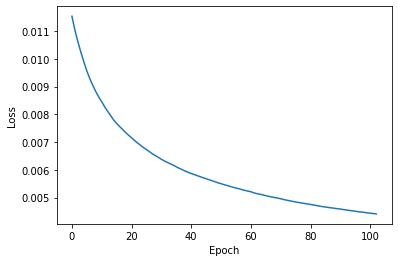

In [50]:
sns.lineplot(x=loss_plot['Epoch'], y=loss_plot['Loss'])